In [1]:
import os
import torch
print(torch.cuda.is_available())

## RAG
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage

from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

## Multi-turn
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState

## Agent, Graph
from langgraph.graph import END
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt import ToolNode, tools_condition


from IPython.display import Image, display

from app.src.v1.db.mongo import connect_to_mongo


from dotenv import load_dotenv

load_dotenv("./keys.env")

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")


LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY

True


In [2]:
llm = ChatOpenAI(model="gpt-4o", temperature=0, api_key=OPENAI_API_KEY)

In [3]:
embed_model_name = "intfloat/multilingual-e5-large-instruct"
index_path = "./indexes/2025-04-10-01-02-18"


model_kwargs = {
    "device": "cuda:1",
    "trust_remote_code": True
}
encode_kwargs = {
    "normalize_embeddings": True,
    "batch_size": 128,
    "multi_process": True,
    "show_progress": True
}

embedding_model = HuggingFaceEmbeddings(
    model_name=embed_model_name, 
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

vector_store = FAISS.load_local(index_path, embeddings=embedding_model, allow_dangerous_deserialization=True)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=10)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    
    return serialized, retrieved_docs

In [5]:
def query_or_respond(state:MessagesState):
    """검색 툴을 호출하거나 직접 응답을 생성"""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}

In [6]:
def generate(state:MessagesState):
    """응답을 생성하는 노드"""

    recent_tool_messages = [] ## 생성된 ToolMessage를 저장할 리스트
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1] ## 역순으로 정렬
    docs_content = "\n\n".join(doc.content for doc in tool_messages) ## 검색된 문서들을 프롬프트에 반영할 수 있도록 문자열로 변환

    ## 시스템 프롬프트
    system_message_content = (
        "지금부터 특정 기업과 관련된 문서들과 질문을 받게 될 것이다."
        "주어진 문서 내용들을 상세하게 파악하고 분석해서 질문에 알맞는 답변을 제공해라."
        "\n\n"
        f"{docs_content}"
    )

    ## 대화 메시지 추출
    conversation_messages = []
    for message in state["messages"]:
        ## 사용자나 시스템 메세지 포함
        if message.type in ("human", "system"):
            conversation_messages.append(message)
        
        ## AI 메세지이고 툴 호출이 없는 경우 포함
        elif message.type == "ai" and not message.tool_calls:
            conversation_messages.append(message)
    
    ## 시스템 메시지와 대화 메시지 결합
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

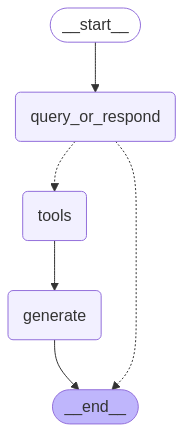

In [7]:
memory = MemorySaver()
graph_builder = StateGraph(MessagesState)
tools = ToolNode([retrieve])

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges("query_or_respond", tools_condition, {END:END, "tools":"tools"})
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
config = {"configurable": {"thread_id": "culture_vision_test_0001"}}

target_name = "LG CNS"
keywords = [
    "혁신","고객","도전","성장",
    "최고지향","창조","전문성","상생",
    "소통","사회공헌","인재","열정",
    "문제해결","성과","즐거움","신속성"
]

In [9]:
# 1단계: 키워드 정의 요청
input_message = f"""{target_name}라는 회사의 비전과 관련된 내용들 중 {keywords[0]}는 어떤 내용으로 제시되고 있는지 파악해서 구체적으로 서술해라.
최소 4가지 이상의 내용을 제시해야 하고, {keywords[0]}과 관련되지만 중복을 허용하지 않는다.
"""

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

response_content = step["messages"][-1].content

================================ Human Message =================================

LG CNS라는 회사의 비전과 관련된 내용들 중 혁신는 어떤 내용으로 제시되고 있는지 파악해서 구체적으로 서술해라.
                최소 4가지 이상의 내용을 제시해야 하고, 혁신과 관련되지만 중복을 허용하지 않는다.
                
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_vUPDmpaTfQGOPKvhVyns9QJ0)
 Call ID: call_vUPDmpaTfQGOPKvhVyns9QJ0
  Args:
    query: LG CNS 비전 혁신
================================= Tool Message =================================
Name: retrieve

Source: {'company_name': '엘지씨엔에스', 'url': 'https://www.lgcns.com/company/about/vision', 'original_doc_id': 'dca84d56-3bb8-49fd-b679-3d3652360046'}
Content: 본문 바로가기
메뉴
Vision
국내 대표 DX 전문기업 LG CNS는 고객이 가장 신뢰하고 인정하는
Digital Business Innovator입니다.
LG CNS는 독보적인 DX 전문성과 차별화된 서비스로
고객의 비즈니스 효율성을 제고하며 국내 DX 시장을 선도하고 있습니다.
나아가, LG CNS는 고객에게 가장 신뢰받는 ‘Digital Business Innovator’로 자리매김하고 있으며,
국내 대표 DX기업을 넘어 글로벌 ‘AX Company’로 한단계 더 도약하고자 합니다.
TOP
문의하기 사이트맵
개인정보처리방침 개인정보처리방침 변경

In [11]:
core_content = response_content
input_message = f"""{target_name} 회사의 문서들을 다시 한 번 검색하고, 이를 참고하면서 다음 단계에 따라 평가 질의와 채점 기준을 정의해라. 마지막 단계에서 [템플릿]에 따라 만든 내용만 출력하고, 중간 단계에서 생성한 값이나 다른 말은 절대 하지 않는다.
                
[1단계]
- {core_content}를 기준으로 제시할 수 있는 질의를 정의한다.
- 질의는 무작정 생성하는게 아니라 문서 내용들을 참고했을 때 채점할 수 있는가를 고려해서 정의해야 한다.
- 최소 4가지 이상의 질의를 정의해야 한다.
- 각 질의별로 중요도(가중치)를 고려해야 한다.

[2단계]
- 각 질의별로 정량적 채점 기준을 정의한다.
- 채점 기준은 0~5점 사이의 정수로 정의되어야 한다.
- 채점 기준은 문서 내용으로부터 제시할 수 있는 사실기반, 수치 등의 구체적인 내용이어야 한다.

[3단계]
아래 제시된 [템플릿]에 따라 평가 질의와 채점 기준을 정의하고 이를 출력한다.
    
    [템플릿]
    1. **평가기준 제목**
    - [평가기준]
        * 상세한 평가기준 내용
        * 현재 평가기준에 적용될 가중치(중요도).

    - [채점기준]
        * 상세한 채점기준 내용
        * 어떠한 기준을 충족하면 어떤 점수를 부여할 것인지 정량적인 기준이 제시어야 함.
        * 충족 기준은 '매우 많고', '적고' 와 같은 추상적인 표현이 아니라 문서 내용으로부터 제시할 수 있는 사실기반, 수치 등의 구체적인 내용이어야 함.

    ### 최종 점수 산출 방법
    1. 각 평가 기준별로 1~5점 배점 후 가중치 적용:
    - (기준1 점수 × 0.25) + (기준2 점수 × 0.25) + (기준3 점수 × 0.25) + (기준4 점수 × 0.25)
    2. 각 단계별 추론 과정을 바탕으로 산출된 점수를 합산하여 최종 점수를 소수점 첫째 자리까지 표기 (예: 4.2).                
"""

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

response_content = step["messages"][-1].content
print(response_content)

================================ Human Message =================================

LG CNS 회사의 문서들을 다시 한 번 검색하고, 이를 참고하면서 다음 단계에 따라 평가 질의와 채점 기준을 정의해라. 마지막 단계에서 [템플릿]에 따라 만든 내용만 출력하고, 중간 단계에서 생성한 값이나 다른 말은 절대 하지 않는다.
                
                [1단계]
                - 1. **디지털 비즈니스 혁신**
- [평가기준]
    * LG CNS가 디지털 비즈니스 혁신을 통해 고객의 비즈니스 효율성을 얼마나 제고하고 있는지 평가.
    * 현재 평가기준에 적용될 가중치: 0.25

- [채점기준]
    * LG CNS가 제공하는 디지털 전환(DX) 서비스의 차별화된 요소가 몇 가지인지에 따라 점수 부여.
    * 5점: 5가지 이상의 차별화된 서비스 제공
    * 4점: 4가지 차별화된 서비스 제공
    * 3점: 3가지 차별화된 서비스 제공
    * 2점: 2가지 차별화된 서비스 제공
    * 1점: 1가지 차별화된 서비스 제공
    * 0점: 차별화된 서비스 없음

2. **비즈니스 컨설턴시 역량 강화**
- [평가기준]
    * LG CNS가 비즈니스 컨설턴시 역량을 통해 고객경험 혁신에 얼마나 기여하고 있는지 평가.
    * 현재 평가기준에 적용될 가중치: 0.25

- [채점기준]
    * 고객에게 제안한 비즈니스 가치의 수와 그에 따른 혁신 사례의 수에 따라 점수 부여.
    * 5점: 5가지 이상의 혁신 사례
    * 4점: 4가지 혁신 사례
    * 3점: 3가지 혁신 사례
    * 2점: 2가지 혁신 사례
    * 1점: 1가지 혁신 사례
    * 0점: 혁신 사례 없음

3. **글로벌 AX 전문 기업으로의 도약**
- [평가기준]
    * LG CNS가 글로벌 시장에서 AX 전문 기업으로 도약하기 위한